**1** Прочитайте и проанализируйте данные, выберите турниры, в которых есть данные о составах команд и повопросных результатах (поле mask в results.pkl). Для унификации предлагаю:
* взять в тренировочный набор турниры с dateStart из 2019 года;
* в тестовый — турниры с dateStart из 2020 года.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime as dt
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.preprocessing import OneHotEncoder
import pickle

In [2]:
train_year = 2019
test_year = 2020

In [3]:
players = pickle.load(open('chgk/players.pkl', 'rb'))
tournaments = pickle.load(open('chgk/tournaments.pkl', 'rb'))
results = pickle.load(open('chgk/results.pkl', 'rb'))

In [4]:
parse_data = []
for tournament in tournaments.keys():    
    if results[tournament] != []:
        year = int(tournaments[tournament]['dateStart'][:4])
        if year in [2019, 2020]:
            for team in results[tournament]:
                mask = team.get('mask')
                if mask is None or '?' in mask or 'X' in mask:
                    continue
                else:
                    for i, answer in enumerate(team['mask']):
                        question_id = tournament * 500 + i 
                        for member in team['teamMembers']:
                            data = dict()
                            data['player_id'] = member['player']['id']
                            data['question_id'] = question_id
                            data['team_id'] = tournaments[tournament]['id']
                            data['answer'] = int(answer)
                            data['year'] = year
                            parse_data.append(data)
                                                     

In [5]:
data_df = pd.DataFrame.from_dict(parse_data) 
with open('chgk/data_df.pkl', 'wb') as f:
    pickle.dump(data_df, f)

In [6]:
data_df = pickle.load(open('chgk/data_df.pkl', 'rb'))

In [7]:
players_df = pd.DataFrame.from_dict(players, orient='index') 
with open('chgk/players_df.pkl', 'wb') as f:
    pickle.dump(players_df, f)

In [8]:
players_df = pickle.load(open('chgk/players_df.pkl', 'rb'))

In [9]:
train = data_df[data_df['year'] == train_year]
test = data_df[data_df['year'] == test_year]

In [10]:
train = pd.merge(train, players_df, left_on=['player_id'], right_on=['id'])
test = pd.merge(test, players_df, left_on=['player_id'], right_on=['id'])

In [11]:
with open('chgk/train_df.pkl', 'wb') as f:
    pickle.dump(train, f)
with open('chgk/test_df.pkl', 'wb') as f:
    pickle.dump(test, f)

In [12]:
train_df = pickle.load(open('chgk/train_df.pkl', 'rb'))
test_df = pickle.load(open('chgk/test_df.pkl', 'rb'))

**2** Постройте baseline-модель на основе линейной или логистической регрессии, которая будет обучать рейтинг-лист игроков. Замечания и подсказки:
* повопросные результаты — это фактически результаты броска монетки, и их предсказание скорее всего имеет отношение к бинарной классификации;
* в разных турнирах вопросы совсем разного уровня сложности, поэтому модель должна это учитывать; скорее всего, модель должна будет явно обучать не только силу каждого игрока, но и сложность каждого вопроса;
* для baseline-модели можно забыть о командах и считать, что повопросные результаты команды просто относятся к каждому из её игроков.

Введем оценку сложности вопроса, как отношение количесва команд верно ответивших на данный вопрос к общему числу команд, отвечавших на данный вопрос. 

In [13]:
def questions_complexity(data_df):
    summa = data_df.groupby(['question_id'])['answer'].sum()
    count = data_df.groupby(['question_id'])['answer'].count()
    complexity = summa.div(count)
    data_df = pd.merge(data_df, complexity, on=['question_id'])
    data_df.rename(columns={'answer_y':'complexity'}, inplace=True)
    return data_df
    

In [14]:
data_df = train_df

In [15]:
questions_complexity_df = questions_complexity(data_df)

In [16]:
with open('chgk/questions_complexity_df.pkl', 'wb') as f:
    pickle.dump(questions_complexity_df, f)

In [17]:
questions_complexity_df = pickle.load(open('chgk/questions_complexity_df.pkl', 'rb'))

Построим распределение сложности вопросов в выборке.

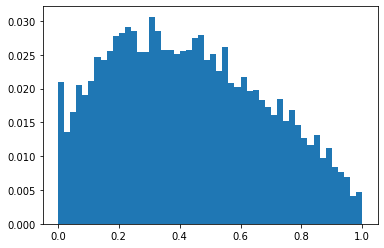

In [18]:
complexity = list(questions_complexity_df['complexity'])
weights = np.ones_like(complexity)/(len(complexity))
distribution = plt.hist(complexity, weights=weights, bins = 50)

In [19]:
group_data = questions_complexity_df.groupby(['player_id'])[['complexity','answer_x']]

In [20]:
from tqdm import tqdm

In [21]:
rating = []
for player in tqdm(list(questions_complexity_df['player_id'].unique())):
    comp, ans = np.asarray([[_] for _ in group_data.get_group(player)['complexity']], dtype=np.float32),\
        group_data.get_group(player)['answer_x'].to_numpy()
    #reg = LinearRegression()
    reg = LogisticRegression()
    if sum(ans) == 0:
        rating.append((player, 0))
        continue
    reg.fit(comp, ans)    
    rating.append((player, np.dot(reg.predict_proba([[i] for i in distribution[1][0:50]])[:, 1], distribution[0])))
        

100%|███████████████████████████████████████████████████████████████████████████| 57288/57288 [09:24<00:00, 101.46it/s]


In [22]:
maximum = 0
for x in rating:
    maximum = max(x[1], maximum)
maximum

0.9722238431466425

In [23]:
rating_df = pd.DataFrame(rating, columns =['id', 'player_rating'])
with open('chgk/rating_df.pkl', 'wb') as f:
    pickle.dump(rating_df, f)

In [24]:
rating_df = pickle.load(open('chgk/rating_df.pkl', 'rb'))

In [25]:
rating_df = questions_complexity_df.merge(rating_df, left_on=['player_id'], right_on=['id'])

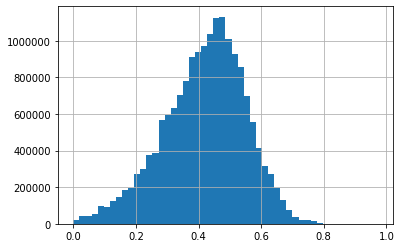

In [26]:
rating_df['player_rating'].hist(bins=50)

In [27]:
players = rating_df[['player_id', 'player_rating']].drop_duplicates()
top_10 = players.sort_values('player_rating', ascending=False).head(10)
top_10 = pd.merge(top_10, players_df, left_on=['player_id'], right_on=['id'])
top_10[['player_id', 'name', 'patronymic', 'surname','player_rating']]

,player_id,name,patronymic,surname,player_rating
0,36844,Павел,Константинович,Щербина,0.972224
1,186002,Инга,Андрисовна,Лоренц,0.904278
2,202410,Валентина,,Подюкова,0.900452
3,133504,София,Евгеньевна,Лебедева,0.894155
4,171845,Михаил,Владимирович,Завьялов,0.891442
5,170977,Давид,Сергеевич,Кан,0.891442
6,215495,Юлия,,Крюкова,0.884176
7,215496,Наталья,,Артемьева,0.884176
8,215497,Екатерина,,Горелова,0.884176
9,119866,Александр,,Полторак,0.876566


**3** Качество рейтинг-системы оценивается качеством предсказаний результатов турниров. Но сами повопросные результаты наши модели предсказывать вряд ли смогут, ведь неизвестно, насколько сложными окажутся вопросы в будущих турнирах; да и не нужны эти предсказания сами по себе. Поэтому:
* предложите способ предсказать результаты нового турнира с известными составами, но неизвестными вопросами, в виде ранжирования команд;
* в качестве метрики качества на тестовом наборе давайте считать ранговые корреляции Спирмена и Кендалла (их можно взять в пакете scipy) между реальным ранжированием в результатах турнира и предсказанным моделью, усреднённые по тестовому множеству турниров.

Cредняя корреляция Спирмена на тестовом множестве 2020 года во всех моделях, включая baselines, получалась порядка 0.7-0.8, а корреляция Кендалла — порядка 0.5-0.6. Если у вас корреляции вышли за 0.9 или, наоборот, упали ниже 0.3, скорее всего где-то баг.

Будем предсказывать результат нового турнира с известными составами, но неизвестными вопросами исходя из того, что вероятность правильного ответа команды на вопрос: 

$$p(correct\:answer) = 1 - \prod_{n=1}^{N}p_n(uncorrect\:answer)$$

, где N - число членов команды.

In [28]:
from scipy import stats

In [29]:
tournaments = pickle.load(open('chgk/tournaments.pkl', 'rb'))
tournaments_df = pd.DataFrame.from_dict(tournaments, orient='index')
tournaments_test_df = tournaments_df[tournaments_df['dateStart'].str[:4]=='2020']

In [30]:
def win_prob(team):
    prod = 1
    for player_id in team:
        if player_id in players['player_id'].values:
            prod *= (1 - players[players['player_id']==player_id]['player_rating'].values[0])
    return 1 - prod

In [31]:
spearman = []
kendall = []

for tournament_id in tqdm(tournaments_test_df['id']):
    if results[tournament_id] != [] and 'position' in results[tournament_id][0].keys():
        real_score = []
        predicted_score = []
        for team in results[tournament_id]:
            mask = team.get('mask')
            if mask is None or '?' in mask or 'X' in mask:
                continue
            else:
                real_score.append(team.get('position'))
                members = []
                for member in team.get('teamMembers'):
                    members.append(member.get('player').get('id'))
                 
                predicted_score.append(win_prob(members))
                
        spearman.append(stats.spearmanr(np.asarray(predicted_score), -np.asarray(real_score))[0])
        kendall.append(stats.kendalltau(np.asarray(predicted_score), -np.asarray(real_score))[0])

        


100%|████████████████████████████████████████████████████████████████████████████████| 418/418 [02:47<00:00,  2.50it/s]


In [32]:
nan = spearman[0]
spearman = [_ for _ in spearman if _ is not nan]
print('Spearman: ', sum(spearman)/len(spearman))

Spearman:  0.6980580884416875


In [33]:
nan = kendall[0]
kendall = [_ for _ in kendall if _ is not nan]
print('Kendall: ', sum(kendall)/len(kendall))

Kendall:  0.5444618805753404


**4** Теперь главное: ЧГК — это всё-таки командная игра. Поэтому:
* предложите способ учитывать то, что на вопрос отвечают сразу несколько игроков; скорее всего, понадобятся скрытые переменные; не стесняйтесь делать упрощающие предположения, но теперь переменные “игрок X ответил на вопрос Y” при условии данных должны стать зависимыми для игроков одной и той же команды;
* разработайте EM-схему для обучения этой модели, реализуйте её в коде;
* обучите несколько итераций, убедитесь, что целевые метрики со временем растут (скорее всего, ненамного, но расти должны), выберите лучшую модель, используя целевые метрики.




Введем скрытую переменную - вероятность того, что данный игрок ответил на данный вопрос правильно.

На M шаге максимизируем правдоподобие скрытой переменной.

На E шаге предскажем вероятность игрока ответить на данный вопрос, в зависимости от силы игрока и сложности вопроса.

In [75]:
#one-hot encoding 
encoder = OneHotEncoder(handle_unknown='ignore')
encoder.fit(data_df[['player_id', 'question_id']])
data_matrix = encoder.transform(data_df[['player_id', 'question_id']])
counts = np.array((data_matrix != 0).sum(axis=0)).ravel()

In [76]:
def sigmoid(a, b):
    return 1 / (1 + np.exp(-a@b))

def cross_entropy(pred, real):
    return (pred * (1 - real) - (1 - pred) * real)

def log_cross_entropy(pred, real):
    return pred * np.log(real) + (1 - pred) * np.log(1 - real)

In [77]:
weights = np.random.randn(data_matrix.shape[1])
answer_prob = sigmoid(data_matrix, weights) 

In [78]:
data_df['no_answer_prob'] = 1 - answer_prob
group_data_df = data_df[['team_id', 'question_id', 'no_answer_prob']].groupby(by=['team_id', 'question_id'],\
    sort=False, as_index=False).prod()

In [79]:
def trans_index(prods):
    prods.index = (group_data_df['team_id'].apply(str) + group_data_df['question_id'].apply(str)).apply(int)
    return prods[(data_df['team_id'].apply(str) + data_df['question_id'].apply(str)).apply(int)].to_numpy()

In [80]:
def E_step(answer_prob):
    data_df['no_answer_prob'] = 1 - answer_prob
    prods = data_df[['team_id', 'question_id', 'no_answer_prob']].\
        groupby(by=['team_id', 'question_id'], sort=False, as_index=False).prod()['no_answer_prob']
    prods = trans_index(prods)
    hid = answer_prob / (1 - prods)
    hid[data_df['answer'] == 0] = 0
    return hid

def M_step(data_matrix, weights, hid):
    weights = weights.copy()
    for i in range(50):
        answer_prob = sigmoid(data_matrix, weights)
        weights += data_matrix.T@cross_entropy(hid, answer_prob) / counts
    return weights

def likelihood(hid, data_matrix, weights):
    answer_prob = sigmoid(data_matrix, weights)
    return np.mean(log_cross_entropy(hid, answer_prob))

In [81]:
for i in tqdm(range(10)):
    if i == 0:
        answer_prob = sigmoid(data_matrix, weights)
        hid = E_step(answer_prob)
    weights = M_step(data_matrix, weights, hid)
    answer_prob = sigmoid(data_matrix, weights)
    hid = E_step(answer_prob)
    print("Step: %d, Likelihood: %s" % (i, likelihood(hid, data_matrix, weights)), end='\n')





  0%|                                                                                           | 0/10 [00:00<?, ?it/s]



 10%|████████▏                                                                         | 1/10 [03:34<32:07, 214.20s/it]

Step: 0, Likelihood: -0.31908423263398095






 20%|████████████████▍                                                                 | 2/10 [06:22<26:42, 200.34s/it]

Step: 1, Likelihood: -0.2246472754597551






 30%|████████████████████████▌                                                         | 3/10 [09:09<22:12, 190.35s/it]

Step: 2, Likelihood: -0.17636474259455442






 40%|████████████████████████████████▊                                                 | 4/10 [11:55<18:18, 183.09s/it]

Step: 3, Likelihood: -0.1463492711922281






 50%|█████████████████████████████████████████                                         | 5/10 [14:41<14:49, 177.93s/it]

Step: 4, Likelihood: -0.125723219313331






 60%|█████████████████████████████████████████████████▏                                | 6/10 [16:12<10:07, 151.90s/it]

Step: 5, Likelihood: -0.11062105327545876






 70%|█████████████████████████████████████████████████████████▍                        | 7/10 [17:28<06:27, 129.20s/it]

Step: 6, Likelihood: -0.09906213125341586






 80%|█████████████████████████████████████████████████████████████████▌                | 8/10 [18:37<03:42, 111.01s/it]

Step: 7, Likelihood: -0.0899187733733331






 90%|██████████████████████████████████████████████████████████████████████████▋        | 9/10 [19:45<01:38, 98.28s/it]

Step: 8, Likelihood: -0.08249913937915591






100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [20:54<00:00, 125.46s/it]

Step: 9, Likelihood: -0.07635427144188356


In [82]:
with open('chgk/weights.pkl', 'wb') as f:
    pickle.dump(weights, f)
weights = pickle.load(open('chgk/weights.pkl', 'rb'))

In [83]:
data_df['player_rating'] = 0
player_strength = []
question_complexity = []

In [84]:
player_strength = pd.Series(np.zeros(len(data_df['player_id'].unique())), data_df['player_id'].unique())
for i, key in enumerate(sorted(data_df['player_id'].unique())):
    player_strength[key] = weights[i]
    
shift = len(data_df['player_id'].unique())
question_complexity = pd.Series(np.zeros(len(data_df['question_id'].unique())), data_df['question_id'].unique())
for i, key in enumerate(sorted(data_df['question_id'].unique())):
    question_complexity[key] = weights[i + shift]

In [85]:
players = data_df[['player_id', 'player_rating']].drop_duplicates()
players_rating = []

In [86]:
for player in players['player_id']:
    preds = 1 / (1 + np.exp(-(player_strength[player] + distribution[1][0:50]))) 
    rating = np.dot(preds, distribution[0])       
    players_rating.append(rating) 

players['player_rating'] = players_rating

In [87]:
top_10 = players.sort_values('player_rating', ascending=False).head(10)

In [89]:
top_10 = pd.merge(top_10, players_df, left_on=['player_id'], right_on=['id'])
top_10[['player_id', 'name_x', 'patronymic_x', 'surname_x', 'player_rating']]

,player_id,name_x,patronymic_x,surname_x,player_rating
0,36844,Павел,Константинович,Щербина,0.945981
1,12785,Вадим,Александрович,Ишин,0.929120
2,27403,Максим,Михайлович,Руссо,0.904962
3,90527,Дмитрий,Олегович,Вальтер,0.885283
4,195091,Ольга,Фёдоровна,Остросаблина,0.879639
5,27822,Михаил,Владимирович,Савченков,0.850761
6,82688,Игорь,Станиславович,Калгин,0.844716
7,22935,Илья,Сергеевич,Новиков,0.834927
8,28751,Иван,Николаевич,Семушин,0.834908
9,206158,Екатерина,Григорьевна,Золотухина,0.834687


In [90]:
tournaments = pickle.load(open('chgk/tournaments.pkl', 'rb'))
tournaments_df = pd.DataFrame.from_dict(tournaments, orient='index')
tournaments_test_df = tournaments_df[tournaments_df['dateStart'].str[:4]=='2020']

In [92]:
def win_prob(team):
    prod = 1
    for player_id in team:
        if player_id in players['player_id'].values:
            prod *= (1 - players[players['player_id']==player_id]['player_rating'].values[0])
    return 1 - prod

In [93]:
spearman = []
kendall = []
for tournament_id in tqdm(tournaments_test_df['id']):
    if results[tournament_id] != [] and 'position' in results[tournament_id][0].keys():
        real_score = []
        predicted_score = []
        for team in results[tournament_id]:
            mask = team.get('mask')
            if mask is None or '?' in mask or 'X' in mask:
                continue
            else:
                real_score.append(team.get('position'))
                members = []
                for member in team.get('teamMembers'):
                    members.append(member.get('player').get('id'))
                 
                predicted_score.append(win_prob(members))
                
        spearman.append(stats.spearmanr(np.asarray(predicted_score), -np.asarray(real_score))[0])
        kendall.append(stats.kendalltau(np.asarray(predicted_score), -np.asarray(real_score))[0])





  0%|                                                                                          | 0/418 [00:00<?, ?it/s]



  1%|▊                                                                                 | 4/418 [00:00<01:13,  5.62it/s]



  1%|▉                                                                                 | 5/418 [00:00<01:22,  5.00it/s]



  2%|█▊                                                                                | 9/418 [00:01<01:23,  4.92it/s]



  2%|█▉                                                                               | 10/418 [00:02<01:52,  3.62it/s]



  3%|██▏                                                                              | 11/418 [00:02<02:48,  2.41it/s]



  3%|██▎                                                                              | 12/418 [00:03<02:58,  2.28it/s]



  3%|██▌                                                                              | 13/418 [00:03<02:33,  2.64it/s]



  4%|██▉    

In [94]:
nan = spearman[0]
spearman = [_ for _ in spearman if _ is not nan]
print('Spearman: ', sum(spearman)/len(spearman))

Spearman:  0.771547034651011


In [95]:
nan = kendall[0]
kendall = [_ for _ in kendall if _ is not nan]
print('Kendall: ', sum(kendall)/len(kendall))

Kendall:  0.6108992474751299


**5** А что там с вопросами? Постройте “рейтинг-лист” турниров по сложности вопросов. Соответствует ли он интуиции (например, на чемпионате мира в целом должны быть сложные вопросы, а на турнирах для школьников — простые)? Если будет интересно: постройте топ сложных и простых вопросов со ссылками на конкретные записи в базе вопросов ЧГК (это чисто техническое дело, тут никакого ML нету).

In [55]:
tournaments = pickle.load(open('chgk/tournaments.pkl', 'rb'))
tournaments_df = pd.DataFrame.from_dict(tournaments, orient='index')
tournaments_test_df = tournaments_df[tournaments_df['dateStart'].str[:4]=='2019']
results = pickle.load(open('chgk/results.pkl', 'rb'))

In [56]:
tournaments_complexity = {}

for tournament in tqdm(tournaments_test_df['id']):
    tournament_complexity = []
    if results[tournament] != []:
         if 'mask' in results[tournament][0].keys():
            mask = results[tournament][0]['mask']
            if mask is None or '?' in mask or 'X' in mask:
                continue      
            for i in range(len(mask)):
                question_id = tournament * 500 + i                
                tournament_complexity.append(question_complexity[question_id])
            
            tournaments_complexity[tournament] = sum(tournament_complexity)/len(tournament_complexity)
            
tournaments_complexity = pd.Series(tournaments_complexity).sort_values()

100%|██████████████████████████████████████████████████████████████████████████████| 687/687 [00:00<00:00, 2218.49it/s]


Топ-20 cоревнований за 2019 год, что на мой взгляд соответствует интуиции:

In [63]:
for tournament in tournaments_complexity.index[:20]:
    print(tournaments[tournament]["name"])

Чемпионат Санкт-Петербурга. Первая лига
Угрюмый Ёрш
Воображаемый музей
Чемпионат Мира. Этап 3. Группа В
Первенство правого полушария
Чемпионат России
Чемпионат Мира. Этап 2. Группа В
Ускользающая сова
Знание – Сила VI
Тихий Донец: омут первый
Записки охотника
Чемпионат Мира. Этап 2 Группа С
Львов зимой. Адвокат
All Cats Are Beautiful
Чемпионат Мира. Финал. Группа В
Чемпионат Мира. Этап 3. Группа С
Серия Premier. Седьмая печать
Чемпионат Минска. Лига А. Тур четвёртый
Чемпионат Мира. Этап 2. Группа А
Мемориал Дмитрия Коноваленко
